# Random Forest - Fraud_check Dataset

#### Problem Statement :

Use Random Forest to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
fraud = pd.read_csv(r"D:\DATA SCIENCE ASSIGNMENTS\15. RANDOM FOREST\Fraud_check.csv")
fraud.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


## EDA and Data Visualization

In [3]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
fraud.isna().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [5]:
fraud[fraud.duplicated()].shape

(0, 6)

In [6]:
fraud.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


### Outlier Check

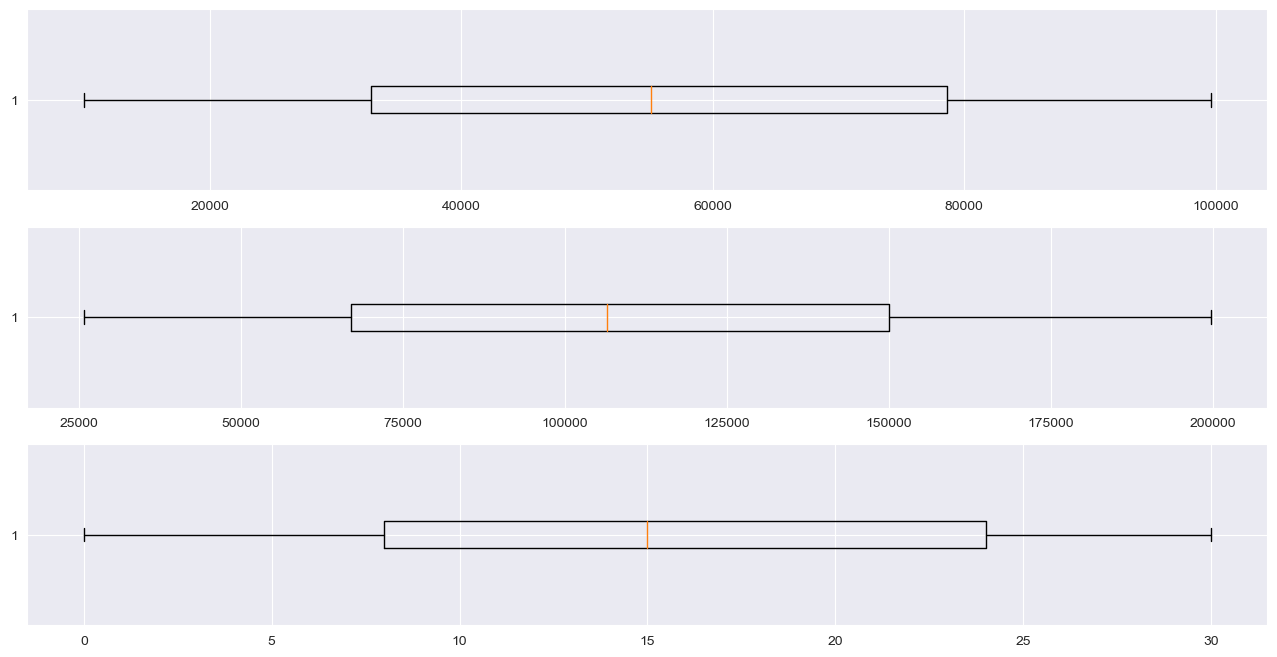

In [7]:
sns.set_style(style='darkgrid')
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.boxplot(fraud["Taxable.Income"], vert=False)

plt.subplot(312)
plt.boxplot(fraud["City.Population"], vert=False)

plt.subplot(313)
plt.boxplot(fraud["Work.Experience"], vert=False)
plt.show()

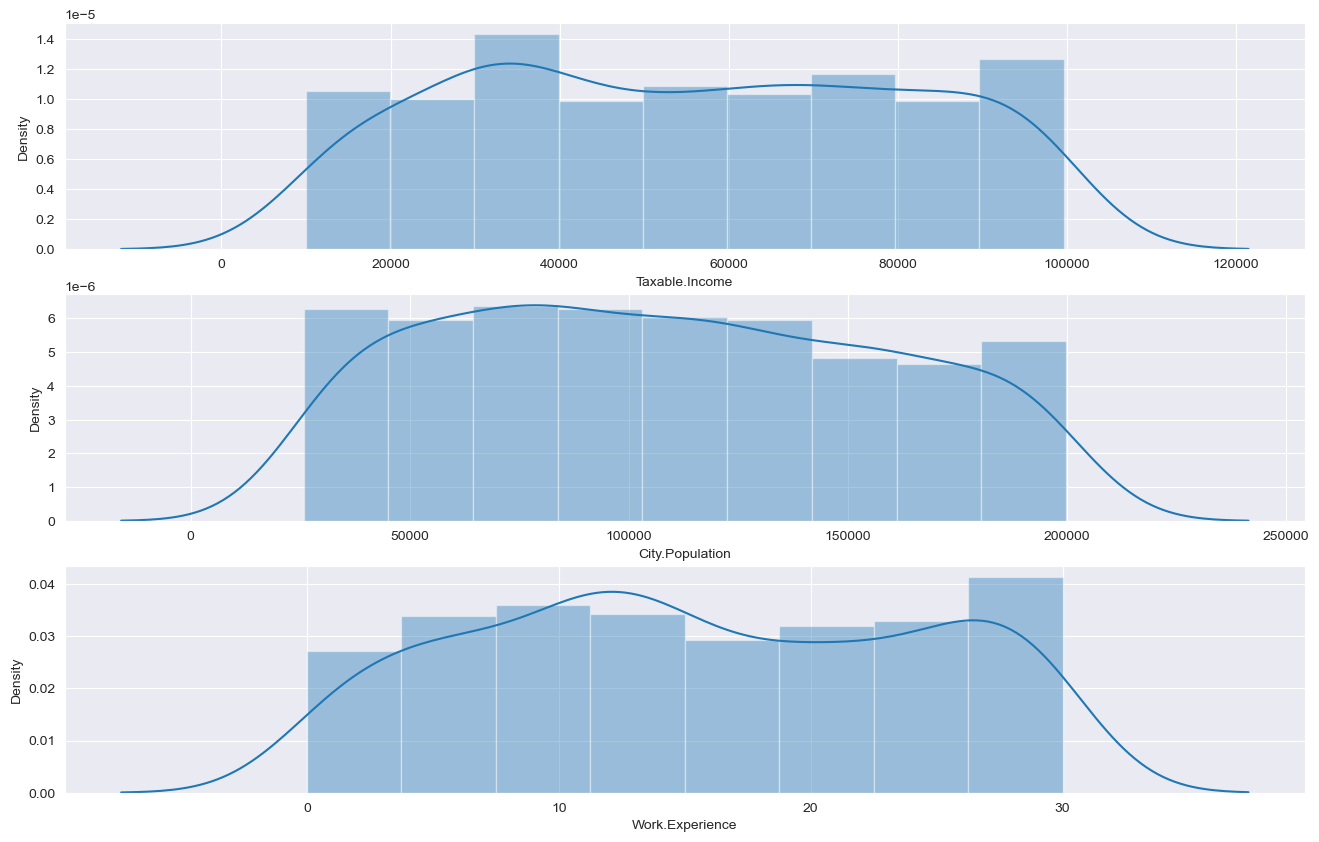

In [8]:
import warnings
plt.figure(figsize=(16,10))
warnings.filterwarnings('ignore')

plt.subplot(311)
sns.distplot(fraud["Taxable.Income"])

plt.subplot(312)
sns.distplot(fraud["City.Population"])

plt.subplot(313)
sns.distplot(fraud["Work.Experience"])
plt.show()

In [9]:
fraud_1 = pd.get_dummies(fraud, columns=["Undergrad", "Marital.Status", "Urban"], drop_first=True)
fraud_1.head()

,Taxable.Income,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES
0,68833,50047,10,0,0,1,1
1,33700,134075,18,1,0,0,1
2,36925,160205,30,0,1,0,1
3,50190,193264,15,1,0,1,1
4,81002,27533,28,0,1,0,0


### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [10]:
print({"Min":fraud_1["Taxable.Income"].min(), "Max":fraud_1["Taxable.Income"].max()})

{'Min': 10003, 'Max': 99619}


In [11]:
fraud_1["Tax.Inc"] = pd.cut(fraud_1["Taxable.Income"], bins=[10002,30000,99620], labels=["Risky", "Good"])
fraud_1.head()

,Taxable.Income,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES,Tax.Inc
0,68833,50047,10,0,0,1,1,Good
1,33700,134075,18,1,0,0,1,Good
2,36925,160205,30,0,1,0,1,Good
3,50190,193264,15,1,0,1,1,Good
4,81002,27533,28,0,1,0,0,Good


In [12]:
fraud_2 = pd.get_dummies(fraud_1, columns=["Tax.Inc"], drop_first=True)
fraud_2.head()

,Taxable.Income,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES,Tax.Inc_Good
0,68833,50047,10,0,0,1,1,1
1,33700,134075,18,1,0,0,1,1
2,36925,160205,30,0,1,0,1,1
3,50190,193264,15,1,0,1,1,1
4,81002,27533,28,0,1,0,0,1


In [13]:
fraud_2.corr()

,Taxable.Income,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES,Tax.Inc_Good
Taxable.Income,1.000000,-0.064387,-0.001818,-0.049232,-0.100611,0.037910,0.070628,0.688725
City.Population,-0.064387,1.000000,0.013135,0.079579,-0.007035,0.002087,-0.040098,-0.012225
Work.Experience,-0.001818,0.013135,1.000000,-0.005362,0.033347,-0.018123,-0.094559,0.001972
Undergrad_YES,-0.049232,0.079579,-0.005362,1.000000,0.015120,0.028883,-0.000267,-0.012523
Marital.Status_Married,-0.100611,-0.007035,0.033347,0.015120,1.000000,-0.520317,0.016771,-0.043178
Marital.Status_Single,0.037910,0.002087,-0.018123,0.028883,-0.520317,1.000000,0.047014,0.015820
Urban_YES,0.070628,-0.040098,-0.094559,-0.000267,0.016771,0.047014,1.000000,-0.004830
Tax.Inc_Good,0.688725,-0.012225,0.001972,-0.012523,-0.043178,0.015820,-0.004830,1.000000


<AxesSubplot:>

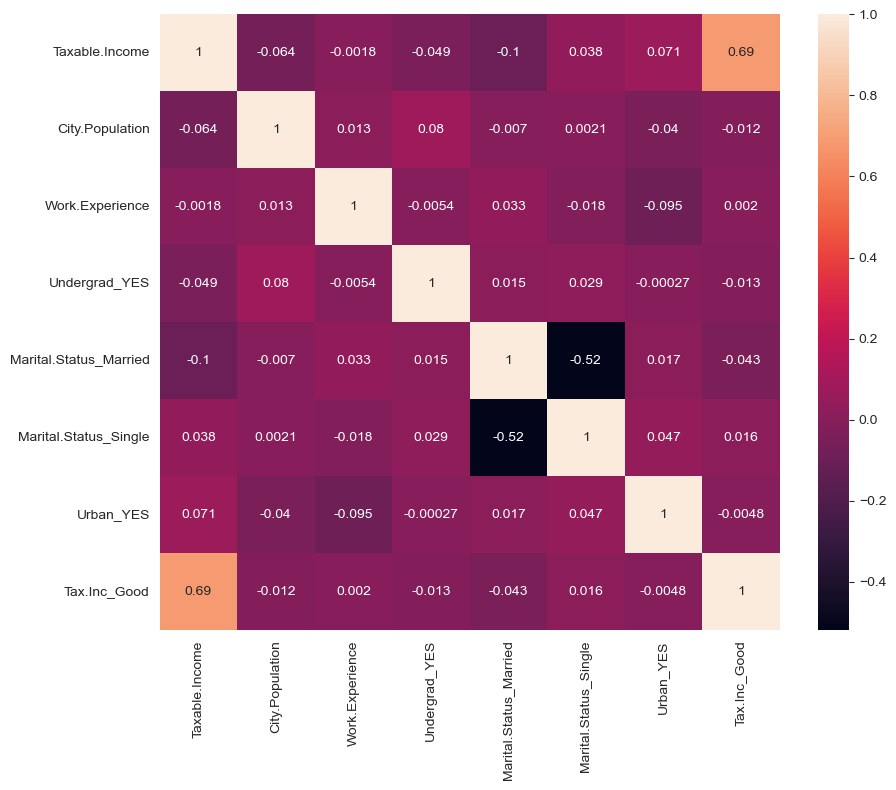

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(fraud_2.corr(), annot=True, cmap='rocket')

## Normalization

In [15]:
def norm_func (i):
    x = (i - i.min())/ (i.max()-i.min())
    return (x)

In [16]:
fraud_norm = norm_func(fraud_2.iloc[:,1:])
fraud_norm.head()

,City.Population,Work.Experience,Undergrad_YES,Marital.Status_Married,Marital.Status_Single,Urban_YES,Tax.Inc_Good
0,0.139472,0.333333,0.0,0.0,1.0,1.0,1.0
1,0.622394,0.600000,1.0,0.0,0.0,1.0,1.0
2,0.772568,1.000000,0.0,1.0,0.0,1.0,1.0
3,0.962563,0.500000,1.0,0.0,1.0,1.0,1.0
4,0.010081,0.933333,0.0,1.0,0.0,0.0,1.0


## K-Fold Cross Validation

In [17]:
x = fraud_2.iloc[:, 0:7]
y = fraud_2.iloc[:, 7]

In [18]:
kfold = KFold(n_splits=10, shuffle=True)

## Building model using Random Forest

In [19]:
model = RandomForestClassifier(n_estimators=100, max_features=3, random_state=7)
model.fit(x,y)
result = cross_val_score(model, x, y, cv=kfold)
print(result.mean())

0.9983333333333333


In [20]:
pred = model.predict(x)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
pd.crosstab(y, pred)

col_0,0,1
Tax.Inc_Good,,
0,124,0
1,0,476


In [22]:
np.mean(pred==y)*100

100.0

#### Conclusion

We get the 100% accuracy for this 'Fraud Check Dataset' when we prepare the model using Random Forest algorithm.